# Python Intermediate: _Imputation and Imbalanced Data_

## ASRI 2022

This notebook and supporting script is also available on GitHub at:

<https://github.com/jcausey-astate/ASRI-2022-Imputation-and-Imbalanced-Data.git>

In [1]:
# We need to download a helper script to get started:
! [[ -f knockout_values.py ]] || wget https://raw.githubusercontent.com/jcausey-astate/ASRI-2022-Imputation-and-Imbalanced-Data/master/knockout_values.py

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  # needed for IterativeImputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from knockout_values import knockout_values
np.random.seed(2022)

## Dataset

The data file ("auto-mpg.data") and data dictionary ("auto-mpg.names") are available for download at the following URIs:

- `auto-mpg.data`
  - <https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data>

- `auto-mpg.names`
  - <https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names>

### Information about the dataset (from "auto-mpg.names")
1. **Title:** _Auto-Mpg Data_

2. **Sources:**
   * Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University. The dataset was 
                used in the 1983 American Statistical Association Exposition.
   * Date: July 7, 1993

3. **Past Usage:**
    -  See 2 (above)
    -  Quinlan,R. (1993). _Combining Instance-Based and Model-Based Learning._
       In Proceedings on the Tenth International Conference of Machine 
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. **Relevant Information:**

   This dataset is a slightly modified version of the dataset provided in
   the StatLib library.  In line with the use by Ross Quinlan (1993) in
   predicting the attribute "mpg", 8 of the original instances were removed 
   because they had unknown values for the "mpg" attribute.  The original 
   dataset is available in the file "auto-mpg.data-original".

   "The data concerns city-cycle fuel consumption in miles per gallon,
    to be predicted in terms of 3 multivalued discrete and 5 continuous
    attributes." (Quinlan, 1993)

5. **Number of Instances:** 398

6. **Number of Attributes:** 9 including the class attribute

7. **Attribute Information:**

    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)

8. **Missing Attribute Values:**  horsepower has 6 missing values



In [3]:
# Download the data file:
! [[ -f auto-mpg.data ]] || wget https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

In [4]:
# Now, let's load the data from the file into a Pandas dataframe...
# 
# We will use the 'attributes' dictionary to give names to each variable,
# and also to specify its type.
attributes = {
    "mpg": float,        "cylinders": int,
    "displacement": int, "horsepower": float,
    "weight": float,     "acceleration": float,
    "model_year": int,   "origin": int,
    "car_name": str
}
# The Pandas `read_csv()` function will do the import work...
mpg_data = pd.read_csv(
    'auto-mpg.data',
    delim_whitespace=True,  # The data file uses variable amounts of whitespace between values
    header=None,            # There is no header in the data file,
    names=attributes,       # so we will specify our own names and data types
    na_values='?'           # The missing values are marked with '?' in the data file.
)

**Classification Task**  To make a classification dataset, we can try to predict the number of cylinders given the other information, including the mpg values.

In [5]:
# here is some information about what we have to work with (notice the
# 398 - 6 = 392 non-null values for horsepower, since 6 were missing).
mpg_data.info()
print(f"\nNumber of classes based on cylinder count: {mpg_data['cylinders'].unique().shape[0]}")
print(mpg_data['cylinders'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB

Number of classes based on cylinder count: 5
4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64


For this workshop, it will be easier if we start with no missing values at all, so let's drop the rows that contain missing horsepower values.  (By the way, that is the first option for dealing with missing values - if there aren't too many, just drop those rows!)

In [6]:
mpg_data = mpg_data.dropna(how='any')
mpg_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   model_year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car_name      392 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 30.6+ KB


Let's also drop the car name column.  Why?  Well, the car name and year together could immediately allow mpg (and cylinder count) lookup, not requiring any other variable.  We really want our models to work with as many variables as possible so that we can evaluate imputation methods.

In [7]:
mpg_data = mpg_data.drop('car_name', axis=1)
mpg_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   model_year    392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


Let's create a version of the data that has 50% missing values. (Yes, that's a lot!)

> Note: The "*knockout_values.py*" module contains the definition for
> the function `knockout_values()` that is used below to simulate the missing values.
> Feel free to look over the code there, or re-use and adapt it for your own 
> experiments in the future.

In [8]:
np.random.seed(42)
masked_50, mask_50 = knockout_values(mpg_data, missing_pct=0.50, exclude=['mpg']) # drop 1/2 of the values

We will create a separate view with different data dropped for use with the _classification_ task.  The same amount of data will be dropped.  Since the classification task uses `cylinders` as the ground truth, we will not drop any values in that column.

In [9]:
np.random.seed(42)
cls_masked_50, cls_mask_50 = knockout_values(mpg_data, missing_pct=0.50, exclude=['cylinders']) # drop 1/2 of the values

And, to make training and evaluation easier, we will separate the class, mpg, and random variables into separate views:

In [10]:
y_class = mpg_data['cylinders']
y_mpg   = mpg_data['mpg']
X_full  = mpg_data.drop(['mpg'], axis=1)
X_cls_full = mpg_data.drop(['cylinders'], axis=1)
X_50    = masked_50.drop(['mpg'], axis=1)
X_cls_50 = cls_masked_50.drop(['cylinders'], axis=1)

Let's create models for both regression and classification tasks.  We will use a linear model for each task and compare the results with a random forest model.

The linear models will perform better if the values of the input variables are in a similar numeric range, so we will use the handy `sklearn.preprocessing.StandardScaler()`, which modifies the values of each feature (variable) so that they have a mean of zero and a variance of 1.

To apply the standardization before the classification in the cross-validation function, we will use another handy Scikit-Learn tool: the `make_pipeline()` function, which takes a series of steps that you want to run the data through (in the form of Scikit-Learn objects that support the `fit` method).  Data will be fed through each step in series, and the final results returned.

In [11]:
reg_full_model1 = make_pipeline(
    StandardScaler(),
    LinearRegression()
)
reg_full_model2 = RandomForestRegressor(criterion='squared_error')
cls_full_model1 = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)
cls_full_model2 = RandomForestClassifier()

In [12]:
np.random.seed(42)
cls_res1 = cross_validate(cls_full_model1, X=X_cls_full.values, y=y_class.values, cv=5, scoring='balanced_accuracy')
cls_res2 = cross_validate(cls_full_model2, X=X_cls_full.values, y=y_class.values, cv=5, scoring='balanced_accuracy')
reg_res1 = cross_validate(reg_full_model1, X=X_full.values, y=y_mpg.values, cv=5, scoring='neg_mean_squared_error')
reg_res2 = cross_validate(reg_full_model2, X=X_full.values, y=y_mpg.values, cv=5, scoring='neg_mean_squared_error')

print(f"linear classification acc       : {cls_res1['test_score'].mean() * 100:0.1f}%")
print(f"random forest classification acc: {cls_res2['test_score'].mean() * 100:0.1f}%")
print(f"linear regression mean abs. error (mpg)       : {np.sqrt(-reg_res1['test_score'].mean()):0.2f}")
print(f"random forest regression mean abs. error (mpg): {np.sqrt(-reg_res2['test_score'].mean()):0.2f}")

/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


linear classification acc       : 63.8%
random forest classification acc: 72.2%
linear regression mean abs. error (mpg)       : 3.88
random forest regression mean abs. error (mpg): 3.14


If we try to do the same experiment with the version of our dataset containing missing
values, we will get errors, concluding in a paragraph similar to:

```
...
ValueError: Input X contains NaN.
Normalizer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
```

We need to find a way to handle the missing values.  There are basically three ways we could proceed:

1. Use a model that can handle missing values.
2. Either remove any sample that contains a missing value, or remove any variable that contains a missing value.
3. Try to find reasonable *estimates* of the missing values.  This process is called *imputation*.

For this workshop, we will ignore #1 since a model that can handle missing values is not always the best choice for the problem we are wanting to solve.  (If such a model would work well for your problem, #1 is a viable option.)  

We will also ignore option #2 for now, since dropping all rows (or columns) with missing values would reduce the size of our dataset too severely.  (Note: If you only have a few missing values, option #2 is a perfectly reasonable choice.)

That leaves us with option #3: **_imputation_**.  Generally speaking, imputation includes any method of replacing a missing value with an estimate of that value...  There are many ways to do this.  A few common ones are:

1) Replace missing values with a constant value (like zero).
2) Replace missing values with the *mean* or *median* value for the corresponding variable.
3) (In timeseries or timeseries-like data) replace the missing value with the previous (or next) value.
4) Replace the missing value with a random value chosen from the available examples (in that variable).  This can be done 'smarter' if you have a way to choose from only "similar" samples.
5) Replace the missing value with the result of a predictive model based on available data elsewhere in the dataset.  (Notice that this is more expensive than previous options - now you are fitting a predictive model to *impute* before fitting the predictive model you wanted in the first place.)
6) Something even more exotic:  Build some kind of model that can simulate "plausible" values for the missing data point.  (GANs are an example of this.)

**Scikit-Learn** has some built-in support for several different [imputation](https://scikit-learn.org/stable/modules/generated/impute.html) techniques:

* `SimpleImputer()`:  Imputation transformer for completing missing values.
* `IterativeImputer()` : Multivariate imputer that estimates each feature from all the others.
* `KNNImputer()`: Imputation for completing missing values using k-Nearest Neighbors.

The library also has a related class for creating a mask showing where missing values are before performing imputation, which is useful to quantifying the performance of imputation algorithms in some use cases:

* `MissingIndicator()`: Binary indicators for missing values.

For this workshop, let's try out the `SimpleImputer` and `KNNImputer` tools.  `IterativeImputer` is still marked as 'experimental', and the interface may change in the future, so we will leave that one unexplored for now - but feel free to try the same task with it after this workshop to see how it works!

We will use the same `make_pipeline()` function we used before to apply data standardization to the linear models.  This time we will add the imputation step as the first step in each pipeline - including for the random forest models.  Performance evaluation will then proceed exactly as before.

Our first trial will use a `SimpleImputer` with the "constant" strategy, meaning we will replace the missing values with a single constant value (we will choose 0 for this trial).

In [13]:
imp_strategy = 'constant'
imputer = SimpleImputer(strategy=imp_strategy, fill_value=0)
reg_imp_model1 = make_pipeline(
    imputer,
    StandardScaler(),
    LinearRegression()
)
reg_imp_model2 = make_pipeline(
    imputer,
    RandomForestRegressor(criterion='squared_error')
)
cls_imp_model1 = make_pipeline(
    imputer,
    StandardScaler(),
    LogisticRegression()
)
cls_imp_model2 = make_pipeline(
    imputer,
    RandomForestClassifier()
)

# Now perform the test runs with this imputation configuration:
np.random.seed(42)
cls_imp_res1 = cross_validate(cls_imp_model1, X=X_cls_50.values, y=y_class.values, cv=5, scoring='balanced_accuracy')
cls_imp_res2 = cross_validate(cls_imp_model2, X=X_cls_50.values, y=y_class.values, cv=5, scoring='balanced_accuracy')
reg_imp_res1 = cross_validate(reg_imp_model1, X=X_50.values, y=y_mpg.values, cv=5, scoring='neg_mean_squared_error')
reg_imp_res2 = cross_validate(reg_imp_model2, X=X_50.values, y=y_mpg.values, cv=5, scoring='neg_mean_squared_error')

print(f"linear classification acc       : {cls_imp_res1['test_score'].mean() * 100:0.1f}%")
print(f"random forest classification acc: {cls_imp_res2['test_score'].mean() * 100:0.1f}%")
print(f"linear regression mean abs. error (mpg)       : {np.sqrt(-reg_imp_res1['test_score'].mean()):0.2f}")
print(f"random forest regression mean abs. error (mpg): {np.sqrt(-reg_imp_res2['test_score'].mean()):0.2f}")

/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


linear classification acc       : 34.7%
random forest classification acc: 58.3%
linear regression mean abs. error (mpg)       : 7.56
random forest regression mean abs. error (mpg): 5.31


The performance has dropped pretty significantly, as we would expect since we've removed $\frac{1}{2}$ of the values across the dataset.  The linear classifier is down to ~35% accuracy -- still better than the ~20% you would expect for random guessing with 5 classes, but not great.  The linear regression error (in terms of MPG) has nearly doubled.  The random forest did better, but it still lost significant performance in both tasks.

We could try another arbitrary value for the "constant" imputation strategy, but it would make more sense to pick a different value for each variable - one that is either common or at least likely to occur.  Obvious choices for this are: _mean_ (the average value), _median_ (the mid-point of the variable's range), and _mode_ (the most frequent value, if the values are whole numbers or categorical).

The Scikit-Learn `SimpleImputer` offers all three options ("mean", "median", "most_frequent").  Let's use **_mean_**, which is often a good choice if you don't know anything specific about the variable distributions that would point to toward a different choice.

In [14]:
imp_strategy = 'mean'
imputer = SimpleImputer(strategy=imp_strategy)
reg_imp_model1 = make_pipeline(
    imputer,
    StandardScaler(),
    LinearRegression()
)
reg_imp_model2 = make_pipeline(
    imputer,
    RandomForestRegressor(criterion='squared_error')
)
cls_imp_model1 = make_pipeline(
    imputer,
    StandardScaler(),
    LogisticRegression()
)
cls_imp_model2 = make_pipeline(
    imputer,
    RandomForestClassifier()
)

# Now perform the test runs with this imputation configuration:
np.random.seed(42)
cls_imp_res1 = cross_validate(cls_imp_model1, X=X_cls_50.values, y=y_class.values, cv=5, scoring='balanced_accuracy')
cls_imp_res2 = cross_validate(cls_imp_model2, X=X_cls_50.values, y=y_class.values, cv=5, scoring='balanced_accuracy')
reg_imp_res1 = cross_validate(reg_imp_model1, X=X_50.values, y=y_mpg.values, cv=5, scoring='neg_mean_squared_error')
reg_imp_res2 = cross_validate(reg_imp_model2, X=X_50.values, y=y_mpg.values, cv=5, scoring='neg_mean_squared_error')

print(f"linear classification acc       : {cls_imp_res1['test_score'].mean() * 100:0.1f}%")
print(f"random forest classification acc: {cls_imp_res2['test_score'].mean() * 100:0.1f}%")
print(f"linear regression mean abs. error (mpg)       : {np.sqrt(-reg_imp_res1['test_score'].mean()):0.2f}")
print(f"random forest regression mean abs. error (mpg): {np.sqrt(-reg_imp_res2['test_score'].mean()):0.2f}")

/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


linear classification acc       : 53.6%
random forest classification acc: 55.4%
linear regression mean abs. error (mpg)       : 6.48
random forest regression mean abs. error (mpg): 5.72


Interestingly, the linear classifiers improved a bit with this setting, but the random forest classifiers actually got _worse_ in both classification and regressions tasks.  This is possibly because the constant "zero" value was easy to detect and ignore in the underlying decision trees the random forest uses, while the mean values will be different for every variable.  Using 'median' instead of mean would have similar performance on this problem (but don't take my word for it -- try it yourself).

This goes to show that there is not one "_correct_" imputation technique for all data types and models -- you may have to try more than one to find the right technique, or choose based on knowledge of the dataset (you could get that from an exploratory analysis or domain knowledge).

**Let's take a look at a more advanced imputation strategy** - the `KNNImputer` from Scikit-Learn.  This one uses the idea that similar samples probably have similar values for their variables.  Thus, if you choose $K$ of the most similar samples to the one that has a missing value, and let them "vote" (by taking a mean) for the most likely value that should be placed there, the answer is probably more likely to be correct than if we just average the variable over all samples.

Let's set up the same experiment with `KNNImputer` to see how it works in practice.  

The value of $K$ is the tuning parameter we would need to experimentally select if we wanted to maximize performance.  Scikit-Learn calls this parameter `n_neighbors`.  We will arbitrarily set it to 11 here.  The other tuning parameter we will set is `weights`, which determines how the "votes" from neighbors are weighted.  We will use "uniform" to allow all neighbors to have the same amount of influence.

In [15]:
imputer = KNNImputer(n_neighbors=11, weights='uniform')
reg_imp_model1 = make_pipeline(
    imputer,
    StandardScaler(),
    LinearRegression()
)
reg_imp_model2 = make_pipeline(
    imputer,
    RandomForestRegressor(criterion='squared_error')
)
cls_imp_model1 = make_pipeline(
    imputer,
    StandardScaler(),
    LogisticRegression()
)
cls_imp_model2 = make_pipeline(
    imputer,
    RandomForestClassifier()
)

# Now perform the test runs with this imputation configuration:
np.random.seed(42)
cls_imp_res1 = cross_validate(cls_imp_model1, X=X_cls_50.values, y=y_class.values, cv=5, scoring='balanced_accuracy')
cls_imp_res2 = cross_validate(cls_imp_model2, X=X_cls_50.values, y=y_class.values, cv=5, scoring='balanced_accuracy')
reg_imp_res1 = cross_validate(reg_imp_model1, X=X_50.values, y=y_mpg.values, cv=5, scoring='neg_mean_squared_error')
reg_imp_res2 = cross_validate(reg_imp_model2, X=X_50.values, y=y_mpg.values, cv=5, scoring='neg_mean_squared_error')

print(f"linear classification acc       : {cls_imp_res1['test_score'].mean() * 100:0.1f}%")
print(f"random forest classification acc: {cls_imp_res2['test_score'].mean() * 100:0.1f}%")
print(f"linear regression mean abs. error (mpg)       : {np.sqrt(-reg_imp_res1['test_score'].mean()):0.2f}")
print(f"random forest regression mean abs. error (mpg): {np.sqrt(-reg_imp_res2['test_score'].mean()):0.2f}")

/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


linear classification acc       : 51.1%
random forest classification acc: 52.3%
linear regression mean abs. error (mpg)       : 5.74
random forest regression mean abs. error (mpg): 5.39


These results were a bit mixed - the regression results were generally better than the constant value method (although R.F. was a litte lower).  The classification results were not as good as the simpler strategies, though.

**Let's try a more complicated method still** -- this one is still considered "experimental" in Scikit-Learn, but it can be a powerful method.  The `IterativeImputer` uses a secondary model to predict each missing variable based on all of the other available variables in the dataset.  The technique is a bit complicated and it has a lot of tuning parameters available, so see more info on it's [Scikit-Learn documentation page](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html).

Here, we have chosen to tune the values of `imputation_order` (setting it to "random") and `max_iter` (increasing it to 100).  This causes the decision of which variable to work on next to be made at random, and the number of imputation rounds to attempt before settling on a value to 100 (although it can stop early).  This will take a bit longer, since we are fitting a model for imputing each variable, but the results could be better than the methods explored thus far.   Let's try it and see...

In [16]:
imputer = IterativeImputer(imputation_order='ascending', max_iter=200)
reg_imp_model1 = make_pipeline(
    imputer,
    StandardScaler(),
    LinearRegression()
)
reg_imp_model2 = make_pipeline(
    imputer,
    RandomForestRegressor(criterion='squared_error')
)
cls_imp_model1 = make_pipeline(
    imputer,
    StandardScaler(),
    LogisticRegression()
)
cls_imp_model2 = make_pipeline(
    imputer,
    RandomForestClassifier()
)

# Now perform the test runs with this imputation configuration:
np.random.seed(42)
cls_imp_res1 = cross_validate(cls_imp_model1, X=X_cls_50.values, y=y_class.values, cv=5, scoring='balanced_accuracy')
cls_imp_res2 = cross_validate(cls_imp_model2, X=X_cls_50.values, y=y_class.values, cv=5, scoring='balanced_accuracy')
reg_imp_res1 = cross_validate(reg_imp_model1, X=X_50.values, y=y_mpg.values, cv=5, scoring='neg_mean_squared_error')
reg_imp_res2 = cross_validate(reg_imp_model2, X=X_50.values, y=y_mpg.values, cv=5, scoring='neg_mean_squared_error')

print(f"linear classification acc       : {cls_imp_res1['test_score'].mean() * 100:0.1f}%")
print(f"random forest classification acc: {cls_imp_res2['test_score'].mean() * 100:0.1f}%")
print(f"linear regression mean abs. error (mpg)       : {np.sqrt(-reg_imp_res1['test_score'].mean()):0.2f}")
print(f"random forest regression mean abs. error (mpg): {np.sqrt(-reg_imp_res2['test_score'].mean()):0.2f}")

/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


linear classification acc       : 55.1%
random forest classification acc: 55.7%
linear regression mean abs. error (mpg)       : 6.03
random forest regression mean abs. error (mpg): 5.62


Indeed, the results are a little better (although still not as good as the dataset without any missing values).  Here are the original performance metrics from the full dataset for reference:

```
linear classification acc       : 63.8%
random forest classification acc: 72.2%
linear regression mean abs. error (mpg)       : 3.88
random forest regression mean abs. error (mpg): 3.14
```

Our `IterativeImputer` was 8.7% below optimal on linear classification, 16.5% lower on classification with the random forest, and missed the correct regression value by an average of ~2.2 mpg (linear) and ~2.5 mpg (random forest) more than if no values had been missing.

In short, there is no substitute for having a quality dataset with no missing values, but we did a reasonable job of recovering enough of the information to have reasonable performance.  (Also, we might do better with more parameter tuning...)

## Handling very imbalanced classes
Until now, we've been ignoring warnings about some of our classes containing so few values that they cannot be split into 5 partitions for our cross-validation evaluation technique.  Let's look again at the number of values in each class (where classes are determined by # of cylinders):

In [17]:
mpg_data['cylinders'].value_counts()

4    199
8    103
6     83
3      4
5      3
Name: cylinders, dtype: int64

Four and eight cylinder engines are the most common in this dataset, with fewer 6-cylinder engines... But there are also some odd engines out there.  Our data contains four instances of a 3-cylinder engine, and three instances of a 5-cylinder.

Let's think about this differently - let's look at what percentage of the overall dataset falls into each category:

In [18]:
n_samples = mpg_data.shape[0]
print(f"total number of samples: {n_samples}")
class_weights = {}
for idx, c in mpg_data['cylinders'].value_counts().iteritems():
    c_pct = c / n_samples
    class_weights[idx] = c_pct
    print(f"{idx}: {c_pct*100:>5.1f}%")

total number of samples: 392
4:  50.8%
8:  26.3%
6:  21.2%
3:   1.0%
5:   0.8%


**Implications**

Let's think about what this means for a moment.  If we had 5 classes that were all perfectly balanced, we would expect 20% of the samples to fall into each class.  That also implies that our chance of getting a classification assignment correct if we picked a class at random would be 20% (or $\frac{1}{5}$ or $1:5$ odds).

So, if the classes are _balanced_, in a 5-class problem, any classifier that does better than ~20% accuracy is somewhat successful (we say it is "better than chance").  Obviously, higher is still better, but this gives us an idea of what the minimum useful classifier might look like.

**But, our classes are *not* balanced.**

Let's consider a really, really bad classification strategy:

```"Every engine is a 4-cylinder engine."```

In our current dataset, this strategy would give us 50.8% accuracy (unweighted accuracy).  Yet, we can agree that it is not a useful strategy...

If we concentrated on only the 4, 8, and 6 cylinder engines, we get an (unweighted) accuracy of ~98.2%.  That seems really great!  But, it will _never_ be able to "see" a 3 or 5 cylinder engine.  

OK, the stakes are low here (cars), but what if the rare classes were deadly diseases and we were diagnosing people?  We really want to try to build a classifier that has at least a _chance_ of seeing the rare cases as well.

To be fair, let's calculated the _balanced accuracy_ under the same assumption (that a model predicts the top 3 classes perfectly, but never predicts the two rare ones).  The formula involves weighting the number of correct predictions by the percentage that each class represents in the total dataset.  We can calculate it as follows:

$$
acc_{bal} = \sum_{i=0}^k TP_i \cdot (\frac{N_i}{N})
$$
where $TP_i$ means "true positive, class $i$" (correctly predicted for class $i$), $N_i$ means the number of samples in class $i$, and $N$ is the total number of samples.  See the Python code to manually calculate it below:

In [19]:
bal_acc = (
    199 * (199 / n_samples) +
    103 * (103 / n_samples) +
    83  * (83  / n_samples) +
    0   * (4   / n_samples) +
    0   * (3   / n_samples)
) / 392
print(f"balanced acc ignoring two rare cases: {bal_acc*100:0.2f}%")

balanced acc ignoring two rare cases: 37.16%


All of our models (with imputation) were doing better (on average) than 37% accuracy, so they were _probably_ playing somewhat fairly... But let's try to actually look at what they were doing.

For this exercise, we go back to the "full" dataset (no missing values).  We will collect the test-partition predictions from all 5 folds of our cross-validation and produce a visualization known as a _confusion matrix_.  The confusion matrix helps us see where a multi-class classifier is performing well, and identify any weaknesses.  It conveys much more information than a simple accuracy number.

To create the confusion matrix, we need a prediction for all of our data samples.  We can take these predictions when the sample is in the "test" partition of our cross-validation partitioning.  Scikit-Learn has a function to do this automatically: [`sklearn.model_selection.cross_val_predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html).  There are some caveats about predicting for all samples in this way, but for the purposes of our exploration into unbalanced data, it will work just fine.

Let's start by simply collecting predictions for the full dataset without giving any thought to the class imbalance (except to note that the cross-validation framework will do its best to spread the rare examples into separate partitions).

In [20]:
np.random.seed(42)
cls_preds1 = cross_val_predict(cls_full_model1, X=X_cls_full.values, y=y_class.values, cv=5)
cls_preds2 = cross_val_predict(cls_full_model2, X=X_cls_full.values, y=y_class.values, cv=5)
# 
# This time, the result is predictions, not performance scores.  We can calculate the
# balanced accuracy scores though, just to make sure they are close to what we saw in
# the initial experiment:
#
acc1 = balanced_accuracy_score(y_class.values, cls_preds1)
acc2 = balanced_accuracy_score(y_class.values, cls_preds2)
print(f"linear classification acc       : {acc1 * 100:0.1f}%")
print(f"random forest classification acc: {acc2 * 100:0.1f}%")

/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


linear classification acc       : 55.8%
random forest classification acc: 66.1%


The numbers are a little lower, but that is due to the differences in the way the scorer aggregates the results (the `cross_validate()` function averages results from each fold, here we are aggregating _predictions_, then calculating the scoring metric one time).

Let's see what the predictions look like when compared to the _correct_ classifications, in the form of a confusion matrix.

Text(0.5, 1.0, 'Random Forest Classifier')

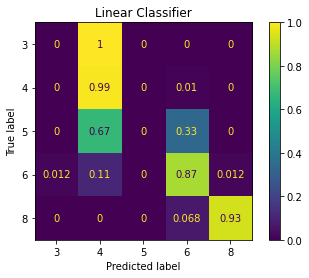

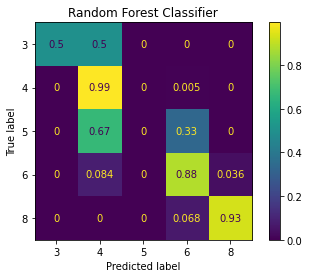

In [21]:
fig1 = ConfusionMatrixDisplay.from_predictions(y_class.values, cls_preds1, normalize='true')
fig1.ax_.set_title("Linear Classifier")
fig2 = ConfusionMatrixDisplay.from_predictions(y_class.values, cls_preds2, normalize='true')
fig2.ax_.set_title("Random Forest Classifier")

**Interpretation:** In the confusion matrix, the rows are arranged according to the _true_ labeling, and the columns are arranged according to the _predicted_ labeling.  So, if we get a prediction _correct_, it will be counted in the square along the diagonal from upper-left to lower-right.  For example, the row labeled "4" contains values for 4-cylinder engines.  Each time we correctly predict 4 cylinders, we increase the value in the row labeled "4" at the column labeled "4" -- we see the value is 0.99 for both models here, meaning they correctly predicted 99% of the actual 4-cylinder cars.  The bad news is there are other shaded squares in the "4" column, meaning the model falsely predicted 4-cylinder for cars that were _not_ 4-cylinder.  We call these _false positive_ predictions.

On the other hand, the linear (logistic regression) classifier _never_ correctly predicted a 3-cylinder car -- it always labeled them as 4-cylinder, and it also falsely predicted that a 6-cylinder car was 3-cylinder!  It also never predicted a 5-cylinder car at all (all zeros in the "5" column).

The random forest did better with 3-cylinder vehicles (50% accuracy for that one), but still never managed to predict a 5-cylinder vehicle at all.

### What can we do to help?
When the dataset is very imbalanced, there are a few approaches that we can try:

1. **Undersampling the majority class(es).**
    * Here, we create a random sampling of the data that simply includes fewer samples of the majority classes, such that the imbalance is lessened.  
    * This is useful if you have a reasonable number of samples of the minority class, but an overwhelming amount of samples from some other class.
    * Since undersampling reduces the overall size of the dataset, it is not a good option if the dataset is already small.
2. **Oversampling the minority class(es).**
    * This time, we are creating a new sampling where we randomly choose examples from the minority classes _with replacement_ so that we include some or all of them multiple times in the dataset, to bring the class representation closer to that of the other classes.
    * This is useful when the total dataset size is not large, or when the minority classes have very small representation.
    * The problem is that just duplicating samples can lead to overfitting the model (where the model "memorizes" the few examples of the minority class it is trained with, but still can't detect new instances in samples it has never seen before).
3.  **Oversampling combined with Undersampling.**
    * Just as the name says, this just means we combine both undersampling of majority classes and oversampling of minority classes.  It tries to balance the benefits and drawbacks of both techniques.
4.  **Augmentation on minority class(es).**
    * This is essentially oversampling, but we don't just add duplicates of the minority class samples.  Instead, we try to generate (simulate) "new" samples that are plausibly still representative of the minority class.  There are _many_ possible ways to do this, and the best methods depend on a deep understanding of the type of data you are working with.
    * Examples include:  In image data, you can rotate / scale, or crop existing images to produce new ones that are still images of the same "thing", but mathematically different enough to discourage memorization by the algorithm.  In tabular data, you can average the values of all variables between two or more existing samples, then add some "noise" to these averaged values to create a new sample that is similar to the existing ones, while not being exactly the same.

We can do some of these with Scikit-Learn directly, but for the more advanced techniques, other libraries are available.  We will take a look at the handy [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn#id32) library, which has Scikit-Learn compatibility.  For today, we will explore _oversampling_ and some _augmentation_ using a commonly used technique called "SMOTE" (Synthetic Minority Oversampling Technique).

In [22]:
# Create the sampler object, then make a pipeline that will resample the training set
# before applying the previous models (linear log. regression and random forest):
ros_default = RandomOverSampler(random_state=42)
ros_pipeline1 = make_pipeline(ros_default, cls_full_model1)
ros_pipeline2 = make_pipeline(ros_default, cls_full_model2)
# Now train and predict with the oversampler in the input pipeline:
np.random.seed(42)
ros_preds1 = cross_val_predict(ros_pipeline1, X=X_cls_full, y=y_class, cv=5)
ros_preds2 = cross_val_predict(ros_pipeline2, X=X_cls_full, y=y_class, cv=5)

/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


linear classification acc       : 77.7%
random forest classification acc: 72.5%


Text(0.5, 1.0, 'Random Forest Classifier + Oversampling')

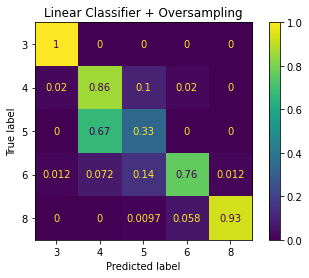

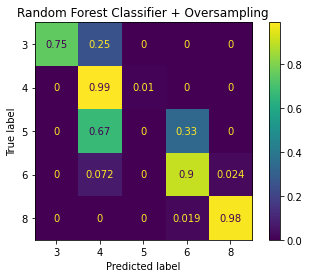

In [23]:
acc1 = balanced_accuracy_score(y_class, ros_preds1)
acc2 = balanced_accuracy_score(y_class, ros_preds2)
print(f"linear classification acc       : {acc1 * 100:0.1f}%")
fig1 = ConfusionMatrixDisplay.from_predictions(y_class, ros_preds1, normalize='true')
fig1.ax_.set_title("Linear Classifier + Oversampling")
print(f"random forest classification acc: {acc2 * 100:0.1f}%")
fig2 = ConfusionMatrixDisplay.from_predictions(y_class, ros_preds2, normalize='true')
fig2.ax_.set_title("Random Forest Classifier + Oversampling")

Well, that is better.  We can see that both models are able to predict the 5-cylinder class now, although the random forest still predicted it incorrectly... And they both do pretty well on the 3-cylinder class.  The linear classifier correctly predicted all of the 3-cylinder vehicles, but unfortunately it also falsely predicted '3' for some 4 and 6 cylinder cars too (false positives).  The random forest even gets nearly perfect performance on the common classes (4, 6, and 8).

Let's try two more advanced techniques that add some augmentation to the oversampling tool.  The first is simply adding a bit of noise to the bootstrap-selected samples (bootstrap is the technique of random re-sampling with replacement).  That way, we don't just get duplicates, but slightly different (noisy) examples.  After that, we will demonstrate the SMOTE technique, which is a powerful tool for many types of data.

First, though:  Let's use "smoothing" with oversampling by setting the `shrinkage` parameter (to 1.0 in this example):

In [24]:
# Create the smoothed sampler object, then make a pipeline that will resample the 
# training set before applying the previous models (linear log. regression and 
# random forest):
ros_smoothed = RandomOverSampler(random_state=42, shrinkage=1.0)
ros_pipeline1s = make_pipeline(ros_smoothed, cls_full_model1)
ros_pipeline2s = make_pipeline(ros_smoothed, cls_full_model2)
# Now train and predict with the oversampler in the input pipeline:
np.random.seed(42)
ros_preds1s = cross_val_predict(ros_pipeline1s, X=X_cls_full, y=y_class, cv=5)
ros_preds2s = cross_val_predict(ros_pipeline2s, X=X_cls_full, y=y_class, cv=5)

/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


linear classification acc       : 78.1%
random forest classification acc: 71.0%


Text(0.5, 1.0, 'Random Forest + Smoothed Oversampling')

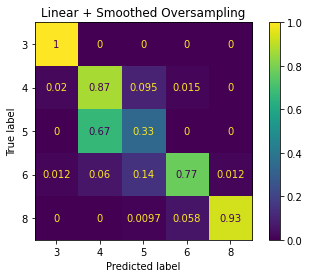

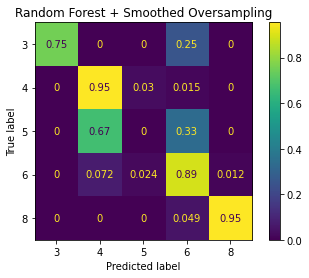

In [25]:
acc1 = balanced_accuracy_score(y_class, ros_preds1s)
acc2 = balanced_accuracy_score(y_class, ros_preds2s)
print(f"linear classification acc       : {acc1 * 100:0.1f}%")
fig1 = ConfusionMatrixDisplay.from_predictions(y_class, ros_preds1s, normalize='true')
fig1.ax_.set_title("Linear + Smoothed Oversampling")
print(f"random forest classification acc: {acc2 * 100:0.1f}%")
fig2 = ConfusionMatrixDisplay.from_predictions(y_class, ros_preds2s, normalize='true')
fig2.ax_.set_title("Random Forest + Smoothed Oversampling")

This one made a little improvement in the linear model, but it actually made the random forest a bit worse.

Now let's try the SMOTE technique:

In [26]:
# Create the SMOTE sampler object, then make a pipeline that will resample the 
# training set before applying the previous models (linear log. regression and 
# random forest).  SMOTENC allows a mixture of continuous and categorical 
# features.  We have model_year and origin that are essentially categorical, 
# so we will pass their positions (using indexes starting at zero) to the 
# `categorical_features` parameter.
smote = SMOTENC(random_state=42, categorical_features=[5,6], k_neighbors=1)
smote_pipeline1 = make_pipeline(smote, cls_full_model1)
smote_pipeline2 = make_pipeline(smote, cls_full_model2)
# Now train and predict with the oversampler in the input pipeline:
np.random.seed(42)
smote_preds1 = cross_val_predict(smote_pipeline1, X=X_cls_full, y=y_class, cv=5)
smote_preds2 = cross_val_predict(smote_pipeline2, X=X_cls_full, y=y_class, cv=5)

/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/jcausey/Dropbox (A-State)/_ASRI_2022/__pypackages__/3.9/lib/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


linear classification acc       : 80.0%
random forest classification acc: 68.0%


Text(0.5, 1.0, 'Random Forest + SMOTE')

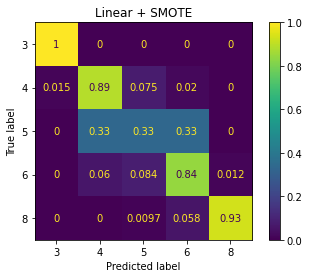

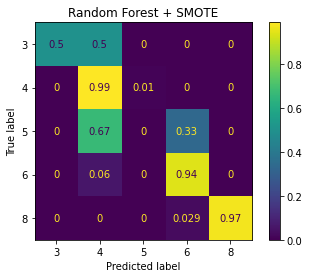

In [27]:
acc1 = balanced_accuracy_score(y_class, smote_preds1)
acc2 = balanced_accuracy_score(y_class, smote_preds2)
print(f"linear classification acc       : {acc1 * 100:0.1f}%")
fig1 = ConfusionMatrixDisplay.from_predictions(y_class, smote_preds1, normalize='true')
fig1.ax_.set_title("Linear + SMOTE")
print(f"random forest classification acc: {acc2 * 100:0.1f}%")
fig2 = ConfusionMatrixDisplay.from_predictions(y_class, smote_preds2, normalize='true')
fig2.ax_.set_title("Random Forest + SMOTE")

OK -- we did better for linear classification, although the 5-cylinder class is still performing poorly.  We did worse still for random forest.  

But, be aware of one big caveat: **We had to set `k_neighbors` all the way down to 1** because there are so few examples of the 5-cylinder class.  This really changes the SMOTE algorithm in a detrimental way.  We had no choice (there were only 3 examples of our smallest class, meaning only 2 were guaranteed to be in the training set in any particular fold)...  Sometimes samples are just too limited to apply the more "clever" augmentation tools.

Let's create a view of the classification dataset that does not include the 3 and 5-cylinder cars, so that we can create an unbalanced set that is slightly less severe, and try SMOTE again without having to dial down the k-neighbors setting.

To make the imbalance as severe as possible, we will downsample the 6-cylinder cars so that there are only 8 of them left.

In [28]:
all_except_3_and_5 = ((y_class != 3) & (y_class != 5))
X_3class = X_cls_full[all_except_3_and_5]
y_3class = y_class[all_except_3_and_5]
# Let's make the class balance worse undersampling the 6-cylinder engines:
rus_X_3class, rus_y_3class = RandomUnderSampler(sampling_strategy={4: 199, 8: 103, 6: 8}).fit_resample(X_3class, y_3class)

Let's classify this 3-class problem with our two models to get a performance baseline:

In [29]:
# Now train and predict with the oversampler in the input pipeline:
np.random.seed(42)
rus_preds1 = cross_val_predict(cls_full_model1, X=rus_X_3class, y=rus_y_3class, cv=5)
rus_preds2 = cross_val_predict(cls_full_model2, X=rus_X_3class, y=rus_y_3class, cv=5)

linear classification acc       : 66.3%
random forest classification acc: 82.7%


Text(0.5, 1.0, 'Random Forest')

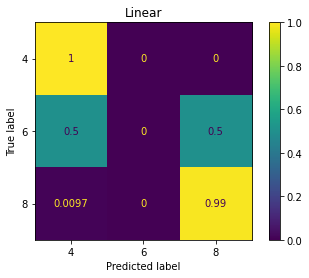

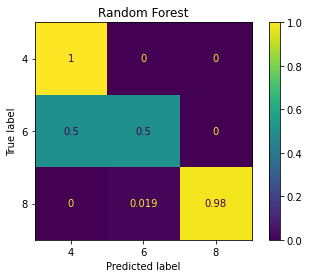

In [30]:
acc1 = balanced_accuracy_score(rus_y_3class, rus_preds1)
acc2 = balanced_accuracy_score(rus_y_3class, rus_preds2)
print(f"linear classification acc       : {acc1 * 100:0.1f}%")
fig1 = ConfusionMatrixDisplay.from_predictions(rus_y_3class, rus_preds1, normalize='true')
fig1.ax_.set_title("Linear")
print(f"random forest classification acc: {acc2 * 100:0.1f}%")
fig2 = ConfusionMatrixDisplay.from_predictions(rus_y_3class, rus_preds2, normalize='true')
fig2.ax_.set_title("Random Forest")

Now, try again with SMOTE to balance dataset:

In [31]:
# Create the SMOTE sampler object, then make a pipeline that will resample the 
# training set before applying the previous models (linear log. regression and 
# random forest).  SMOTENC allows a mixture of continuous and categorical 
# features.  We have model_year and origin that are essentially categorical, 
# so we will pass their positions (using indexes starting at zero) to the 
# `categorical_features` parameter.
smote = SMOTENC(random_state=42, categorical_features=[5,6])
smote_pipeline1 = make_pipeline(smote, cls_full_model1)
smote_pipeline2 = make_pipeline(smote, cls_full_model2)
# Now train and predict with the oversampler in the input pipeline:
np.random.seed(42)
smote_preds1 = cross_val_predict(smote_pipeline1, X=rus_X_3class, y=rus_y_3class, cv=5)
smote_preds2 = cross_val_predict(smote_pipeline2, X=rus_X_3class, y=rus_y_3class, cv=5)

linear classification acc       : 89.9%
random forest classification acc: 91.5%


Text(0.5, 1.0, 'Random Forest + SMOTE')

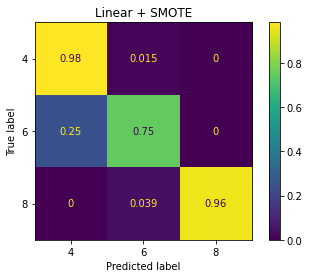

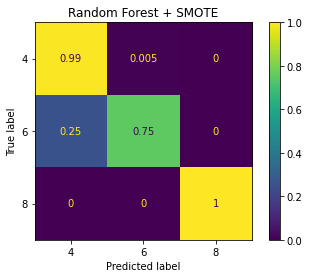

In [32]:
acc1 = balanced_accuracy_score(rus_y_3class, smote_preds1)
acc2 = balanced_accuracy_score(rus_y_3class, smote_preds2)
print(f"linear classification acc       : {acc1 * 100:0.1f}%")
fig1 = ConfusionMatrixDisplay.from_predictions(rus_y_3class, smote_preds1, normalize='true')
fig1.ax_.set_title("Linear + SMOTE")
print(f"random forest classification acc: {acc2 * 100:0.1f}%")
fig2 = ConfusionMatrixDisplay.from_predictions(rus_y_3class, smote_preds2, normalize='true')
fig2.ax_.set_title("Random Forest + SMOTE")

**This made a much bigger difference.**  You can see that SMOTE did manage to overcome the imbalance to produce pretty good classification results, even for the (artificially) challenging 6-cylinder class.

### In conclusion...
There is no substitute for clean, complete, balanced data.  But in the reall world, we have to deal with dirty, incomplete, unbalanced data instead -- it is good to know that there are tools to help us get meaningful results even in these challenging real-world scenarios.

### One more thing...
There is a relatively new technique for producing "plausible" examples of very complex and high-dimensional data.  It is based on _deep learning_, where an artificial neural network is trained to perform a task that would be difficult to explain in traditional mathematical formulation.  The technique is based on using a tool called a _Generative Adversarial Network_ (GAN).  GANs are pairs of models that are designed to "compete" against one another - one is trying to create plausible examples of some kind of data you are interested in, and the other is trying to detect the fakes.

You might have heard of "Deep Fakes", or you may have seen some demos like these:
* [This Person Does not Exist](https://thispersondoesnotexist.com/)
* [This Cat Does not Exist](https://thiscatdoesnotexist.com/)
* (a collection of these is at): [This X Does not Exist](https://thisxdoesnotexist.com/)

Recently, you might have heard of [DALL-E- 2](https://openai.com/dall-e-2/) that can generate amazing works of art given plain english instructions, or [GPT 3](https://www.technologyreview.com/2020/07/20/1005454/openai-machine-learning-language-generator-gpt-3-nlp/) that can write very convincing stories all by itself, given a starting prompt.

This same technology can be used to create "convincing" samples for many kinds of machine learning problems, to aid in augmenting datasets that would otherwise be difficult to gather.  This is the cutting-edge of data augmentation at the moment, and its use is still not universally accepted as valid, but it is an exciting research area and worth mentioning here.

## Thank you, and good luck with your projects!